<a href="https://colab.research.google.com/github/maxmatical/fast.ai/blob/master/imagewang_01_train_supervised_teacher_model_and_generate_pseudolabels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal
1. get some familiarity with fastai 2 end to end
2. try some semi-supervised learning techniques on the imagewang dataset to see which of the following semi-supervised strategies work the best
    - train on labelled data + **ALL** of pseudo-labelled data
    - train on labelled data  + **SOME** of pseudo-labelled data, based on confidence (eg `predicted_proba >= 0.9`)
    - train on labelled data +  **ALL** pseudo-labelled data. Then further fine-tune on labelled data

3. Try step 2 but with soft labels (logits)

In [ ]:
%%capture
!pip install --upgrade fastai

# Train initial model

In [ ]:
import pandas as pd
from fastai.vision.all import *
from fastai.test_utils import show_install
show_install()



```text
=== Software === 
python        : 3.6.9
fastai        : 2.2.5
fastprogress  : 0.2.7
torch         : 1.7.0+cu101
nvidia driver : 418.67
torch cuda    : 10.1 / is available
torch cudnn   : 7603 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : Tesla T4

=== Environment === 
platform      : Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Thu Jul 23 08:00:38 PDT 2020
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be installed with:
pip install distro
Once installed, re-run this utilit

In [ ]:
path = untar_data(URLs.IMAGEWANG)
path.ls()

(#3) [Path('/root/.fastai/data/imagewang/val'),Path('/root/.fastai/data/imagewang/train'),Path('/root/.fastai/data/imagewang/unsup')]

In [ ]:
%ls '/root/.fastai/data/imagewang/train'

n01440764/  n02089973/  n02102040/  n02979186/  n03417042/
n02086240/  n02093754/  n02105641/  n03000684/  n03425413/
n02087394/  n02096294/  n02111889/  n03028079/  n03445777/
n02088364/  n02099601/  n02115641/  n03394916/  n03888257/


creating dataloader from folder

In [ ]:
# defining batch and individual image transforms
size = 224
tfms = aug_transforms(size=size, max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4,
                      p_affine=1., p_lighting=1.)
item_tfms = RandomResizedCrop(460, min_scale=0.75, ratio=(1.,1.)) # used to get images all the same size

# batch transforms
batch_tfms = [*tfms, Normalize.from_stats(*imagenet_stats)]

# creating dataloader
dl = ImageDataLoaders.from_folder(path, train="train", valid="val", batch_tfms=batch_tfms, item_tfms=item_tfms, bs=64)


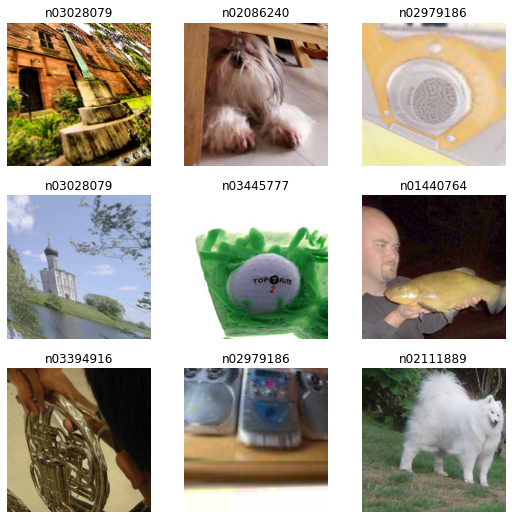

In [ ]:
dl.show_batch()

In [ ]:
dl.vocab

['n01440764', 'n02086240', 'n02087394', 'n02088364', 'n02089973', 'n02093754', 'n02096294', 'n02099601', 'n02102040', 'n02105641', 'n02111889', 'n02115641', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']

In [ ]:
dl.vocab.o2i

{'n01440764': 0,
 'n02086240': 1,
 'n02087394': 2,
 'n02088364': 3,
 'n02089973': 4,
 'n02093754': 5,
 'n02096294': 6,
 'n02099601': 7,
 'n02102040': 8,
 'n02105641': 9,
 'n02111889': 10,
 'n02115641': 11,
 'n02979186': 12,
 'n03000684': 13,
 'n03028079': 14,
 'n03394916': 15,
 'n03417042': 16,
 'n03425413': 17,
 'n03445777': 18,
 'n03888257': 19}

## creating learner

In [ ]:
# need to use this to get rid of a typeerror in learner
def get_model(model, pretrained=False, **kwargs):
    """model: function to load the model, e.g. resnet18
        pretrained, progress: to be passed to the model function
    """
    m = model(pretrained=pretrained, **kwargs) # loads standard model

    return m


In [ ]:
# hyperparameters for ranger

# optional: use the ranger library
sqrmom=0.99
mom=0.95
beta=0.
eps=1e-4
opt_func = partial(ranger, mom=mom, sqr_mom=sqrmom, eps=eps, beta=beta)

# use no pretrained weights
# use xresnet instead of standard resnet
learn = cnn_learner(dl, 
                    partial(get_model, model=xresnet34, pretrained=False),
                    metrics=accuracy,
                    loss_func=LabelSmoothingCrossEntropy(), 
                    opt_func=opt_func).to_fp16()



Downloading: "https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth" to /root/.cache/torch/hub/checkpoints/xrn50_940.pth


In [ ]:
learn.unfreeze();

# learn.summary()


train from scratch

In [ ]:
# learn.lr_find()

In [ ]:
# callbacks
# reduce lr on plateau has lower patience than early stopping so model gets a chance to improve before stopping training
use_mixup = True
model_fname = "/content/drive/MyDrive/imagewang tests/model_05"

cbs = [
    ReduceLROnPlateau(monitor='accuracy',factor=5,patience=3),
    EarlyStoppingCallback(monitor='accuracy', min_delta=0.01, patience=4),
    SaveModelCallback(monitor="accuracy", fname=model_fname)
]
if use_mixup:
    cbs.append(MixUp(0.4))
print(cbs)

[ReduceLROnPlateau, EarlyStoppingCallback, SaveModelCallback, MixUp]


In [ ]:
lr = 0.02
pct_start = 0.3
learn.fit_flat_cos(20, lr=lr, pct_start=pct_start, cbs=cbs)


epoch,train_loss,valid_loss,accuracy,time
0,2.373822,3.693525,0.017816,02:54
1,2.072104,4.197540,0.007636,02:54
2,1.887860,4.284627,0.000000,02:54
3,1.837412,4.365319,0.000000,02:54
4,1.790693,3.625920,0.029524,02:54
5,1.731310,2.987117,0.131331,02:54
6,1.699341,2.737888,0.152202,02:54
7,1.683778,2.881210,0.177144,02:55
8,1.640722,3.337229,0.101807,02:54
9,1.612960,2.404034,0.293968,02:55


Better model found at epoch 0 with accuracy value: 0.01781623810529709.
Epoch 3: reducing lr to 0.004
Better model found at epoch 4 with accuracy value: 0.029524052515625954.
Better model found at epoch 5 with accuracy value: 0.13133113086223602.
Better model found at epoch 6 with accuracy value: 0.1522015780210495.
Better model found at epoch 7 with accuracy value: 0.17714431881904602.
Better model found at epoch 9 with accuracy value: 0.29396793246269226.
Better model found at epoch 11 with accuracy value: 0.3374904692173004.
Better model found at epoch 12 with accuracy value: 0.387630432844162.
Better model found at epoch 13 with accuracy value: 0.44438788294792175.
Better model found at epoch 14 with accuracy value: 0.45278698205947876.
Better model found at epoch 15 with accuracy value: 0.5057266354560852.
Better model found at epoch 16 with accuracy value: 0.5393229722976685.
Better model found at epoch 18 with accuracy value: 0.5688470602035522.


## Results
https://docs.google.com/spreadsheets/d/1nS1_C2y73EpRgvjQ1bhBmnHhev1LVMOU57mZeDpEL6k/edit?usp=sharing

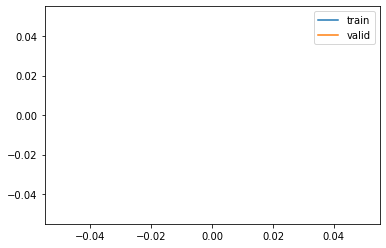

In [ ]:
learn.recorder.plot_loss()

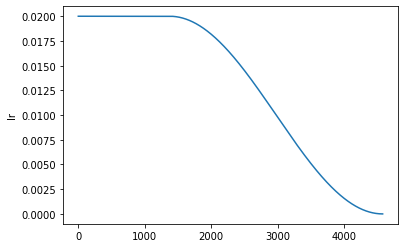

In [ ]:
learn.recorder.plot_sched()

## predict pseudo-labels

predict with `get_preds`

do we need to make sure it's ordered? (doesn't seem like its needed)

In [ ]:
path

Path('/root/.fastai/data/imagewang')

In [ ]:
test_imgs = get_image_files(f"{path}/unsup")
dl_test = learn.dls.test_dl(test_imgs)

In [ ]:
res = learn.get_preds(dl=dl_test, with_decoded=True)

In [ ]:
len(res)

3

`res` is a tuple of length 3 (2 if `with_decoded = False`)

`res[0]` is the raw logits -> a tensor with shape `[n, k]`

`res[1]` is the input labels, will be empty if labels not provided

`res[2]` is the decoded input labels, is a 1d tensor with shape `[n, 1]`

In [ ]:
res[0].shape

torch.Size([7750, 20])

In [ ]:
res[1]

In [ ]:
res[2].shape

torch.Size([7750])

In [ ]:
pred_class = res[2].cpu().numpy()

In [ ]:
pred_class

array([10,  7,  6, ...,  3, 15,  5])

In [ ]:
# convert back into original labels
i2o = {v:k for k,v in dl.vocab.o2i.items()}
i2o

{0: 'n01440764',
 1: 'n02086240',
 2: 'n02087394',
 3: 'n02088364',
 4: 'n02089973',
 5: 'n02093754',
 6: 'n02096294',
 7: 'n02099601',
 8: 'n02102040',
 9: 'n02105641',
 10: 'n02111889',
 11: 'n02115641',
 12: 'n02979186',
 13: 'n03000684',
 14: 'n03028079',
 15: 'n03394916',
 16: 'n03417042',
 17: 'n03425413',
 18: 'n03445777',
 19: 'n03888257'}

In [ ]:
pred_class_orig = [i2o[k] for k in list(pred_class)]
pred_class_orig[:5]
# pred_class_orig

['n02111889', 'n02099601', 'n02096294', 'n03000684', 'n02105641']

In [ ]:
test_img_files = [str(f) for f in test_imgs]
test_img_files[:5]

['/root/.fastai/data/imagewang/unsup/n02111889_16.JPEG',
 '/root/.fastai/data/imagewang/unsup/n02111889_13497.JPEG',
 '/root/.fastai/data/imagewang/unsup/n02096294_7724.JPEG',
 '/root/.fastai/data/imagewang/unsup/n02115641_9685.JPEG',
 '/root/.fastai/data/imagewang/unsup/n02105641_11847.JPEG']

In [ ]:
df_pseudo_labels = pd.DataFrame({"fname": test_img_files, "class": pred_class_orig})
df_pseudo_labels.head(5)

,fname,class
0,/root/.fastai/data/imagewang/unsup/n02111889_16.JPEG,n02111889
1,/root/.fastai/data/imagewang/unsup/n02111889_13497.JPEG,n02099601
2,/root/.fastai/data/imagewang/unsup/n02096294_7724.JPEG,n02096294
3,/root/.fastai/data/imagewang/unsup/n02115641_9685.JPEG,n03000684
4,/root/.fastai/data/imagewang/unsup/n02105641_11847.JPEG,n02105641


create df_train and df_val too from path later, seems like it should be pretty straight forward

## saving model weights and df_pseudo_labels to google drive

In [ ]:
df_pseudo_labels.to_csv("/content/drive/MyDrive/imagewang tests/pseudolabels_05.csv")

In [ ]:
!ls "/content/drive/MyDrive/imagewang tests"

model_01.pth  model_psuedo_01.pth		   pseudolabels_02.csv
model_02.pth  model_psuedo_02.pth		   pseudolabels_03.csv
model_03.pth  model_psuedo_finetune_01_stage2.pth  pseudolabels_04.csv
model_04.pth  model_psuedo_finetune_02_stage2.pth  pseudolabels_05.csv
model_05.pth  pseudolabels_01.csv
